In [27]:
import pandas as pd
import numpy  as np

In [28]:
concrete_data = pd.read_csv('concrete_data.csv')
concrete_data.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [29]:
concrete_data.shape

(1030, 9)

In [30]:
concrete_data.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [31]:
concrete_data.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

In [32]:
target = "Strength"
X = concrete_data.copy()
y = X.pop(target)

In [33]:
X.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [34]:
y.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Strength, dtype: float64

In [35]:
# number of predictors
n_cols      = X.shape[1]
input_shape = (n_cols,)

In [36]:
# Import the train_test_split of scikit-learn
# Will use it later for the train/test split
from sklearn.model_selection import train_test_split

In [37]:
from tensorflow import keras as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [38]:
# define regression model
def regression_model(network_arch,
                     input_shape,
                     optimizer = "adam",
                     loss = "mean_squared_error",
                    ):
    """
    Function to build the regression model
    
    parameters:
    -----------
      - network_arch: dictionary with the following structure
          {"layer_1": {"u_units": n, "activation": activation},
           ...
           "layer_n": {"u_units"}
          }
      - input_shape: tuple with the shape of the input
      - optimizer:   string, name of the optimizer to use
      - loss:        string, name of the loss function to minimize
      
    returns:
    --------
      - A compiled model
    """
    
    # create model
    model = Sequential()
    
    nlayers     = len(network_arch)
    final_layer = "layer_" + str(nlayers)
    
    for k,layer in network_arch.items():
        n_units    = layer.get("n_units")
        activation = layer.get("activation")
        if k == "layer_1":
            model.add(Dense(n_units, activation=activation, input_shape=input_shape))
        elif k == final_layer:
            model.add(Dense(n_units))
        else:
            model.add(Dense(n_units, activation=activation))
    
    # compile model
    model.compile(optimizer=optimizer, loss=loss)
    
    return model

In [39]:
# model architecture
model_architecture1 = {"layer_1": {"n_units": 10, "activation": "relu"},
                       "layer_2": {"n_units":  1},
                      }

print()
print("input_shape    = {}".format(input_shape))
print("network_config = {}".format(model_architecture1))
print()


input_shape    = (8,)
network_config = {'layer_1': {'n_units': 10, 'activation': 'relu'}, 'layer_2': {'n_units': 1}}



In [40]:
# import the metric to evaluate the model performance
from sklearn.metrics import mean_squared_error

In [41]:
# Define a function for the loops 
def train_and_test_several_models(X,y,
                                  test_size,
                                  model_arch,
                                  input_shape,
                                  optimizer,
                                  loss,
                                  niterations,
                                  epochs,
                                  pred_norm = False,
                                  seed = 345,
                                  verbose = 2,
                                 ):
    """
    Function for training and testing several model on random train/test splits
    
    parameters:
    -----------
      - X,y:         the data. X are the predictors and y the target
      - seed:        int, with a seed to be used in the train/test splitting
      - test_size:   float (0,0.5). Size of the test-sample as a fraction of the whole data-set
      - model_arch:  dict. Architecture of the model (see regression_model above)
      - input_shape: 2-tuple with the input shape
      - optimizer:   string. optimizer name
      - loss:        string. loss function name
      - niterations: int. number of iterations to perform the train/test split, model training and testing
      - epoch:       int. number of epochs for model training
      - pred_norm:   bool. If True will apply normalization on the predictors
      - verbose:     int >= 0. level of verbosity.
      
    returns:
    --------
      - mse_results: np.array with the sqrt(mse) metric evaluated on the test-samples
    """
    
    # Array to store the results of the model evaluation on the test set
    metric_list = np.zeros(niterations)
    
    print()
    print("Launching {} iterations of".format(niterations))
    print(" - train/test split => test_size = {}".format(test_size))
    if pred_norm:
        print(" - Apply predictors normalization")
    else:
        print(" - No    predictors normalization")
    print(" - model architecture: {}".format(model_arch))
    print(" - model training:")
    print("   * epochs    = {}".format(epochs))
    print("   * optimizer = {}".format(optimizer))
    print("   * loss      = {}".format(loss))
    print()
    
    # Start the loop
    for i in range(niterations):
        # Apply the train test split
        myseed = seed + i*2 # seed used for the train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=myseed)

        # Start by building the model
        model = regression_model(network_arch = model_arch,
                                 input_shape  = input_shape,
                                 optimizer    = optimizer,
                                 loss         = loss)
        
        if pred_norm:
            # If requested apply predictors normalization
            # first calculate the mean and std on the train-sample
            X_train_mean = X_train.mean()
            X_train_std  = X_train.std()
            
            # then apply them on both, the train and test samples
            X_train = (X_train - X_train_mean)/X_train_std
            X_test  = (X_test  - X_train_mean)/X_train_std

        myverbose = 0
        if i == 0:
            myverbose = verbose
            print("Train/test splitting for iteration {}".format(i+1))
            print("  X_train.shape = {}".format(X_train.shape))
            print("  y_train.shape = {}".format(y_train.shape))
            print("  X_test.shape  = {}".format(X_test.shape))
            print("  y_test.shape  = {}".format(y_test.shape))
            print(X_train.head())
            print()
            print("Model summary for iteration {}".format(i+1))
            model.summary()
            print()
            print()

        # Model training
        model.fit(X_train, y_train, epochs=epochs, verbose=verbose)

        # model predictions on test sample
        y_pred = model.predict(X_test)

        # Model evaluation on test sample
        result = np.sqrt(mean_squared_error(y_test,y_pred))
        print("{}: sqrt(mse) = {}".format(i+1,result))
        metric_list[i] = result
    
    
    print()
    
    return metric_list


In [42]:
niterations = 50  # Number of iterations
test_size   = 0.3 # test sample size

In [43]:
sq_mse_list_A = train_and_test_several_models(X = X,
                                              y = y,
                                              test_size   = test_size,
                                              model_arch  = model_architecture1,
                                              input_shape = input_shape,
                                              optimizer   = "adam",
                                              loss        = "mean_squared_error",
                                              niterations = niterations,
                                              epochs      = 50,
                                              seed        = 345,
                                              verbose     = 0,
                                              pred_norm   = False,
                                             )


Launching 50 iterations of
 - train/test split => test_size = 0.3
 - No    predictors normalization
 - model architecture: {'layer_1': {'n_units': 10, 'activation': 'relu'}, 'layer_2': {'n_units': 1}}
 - model training:
   * epochs    = 50
   * optimizer = adam
   * loss      = mean_squared_error

Train/test splitting for iteration 1
  X_train.shape = (721, 8)
  y_train.shape = (721,)
  X_test.shape  = (309, 8)
  y_test.shape  = (309,)
     Cement  Blast Furnace Slag  Fly Ash  Water  Superplasticizer  \
870   149.0               139.0    109.0  193.0               6.0   
875   155.0               183.0      0.0  193.0               9.0   
488   387.0                20.0     94.0  157.0              14.3   
10    198.6               132.4      0.0  192.0               0.0   
391   397.0                17.2    158.0  167.0              20.8   

     Coarse Aggregate  Fine Aggregate  Age  
870             892.0           780.0   28  
875            1047.0           697.0   28  
488      

In [44]:
# Calculate the mean and the standard deviation of the metric on the 50 samplings
mean_sqmse_A = np.mean(sq_mse_list_A)
std_sqmse_A  = np.std(sq_mse_list_A)

# Generate a data frame to store the results of the differents parts of this project
df_results = pd.DataFrame.from_dict({"Part": ["A"],"mean_sq_mse": [mean_sqmse_A], "std_sq_mse": [std_sqmse_A]})
df_results

,Part,mean_sq_mse,std_sq_mse
0,A,17.056502,8.251775


In [45]:
# Define some common parameters for plotting
figsize = (10,8)
nbins   = 20

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(result_list,
                 label_list,
                 var_name = "sq(mse)",
                 figsize = (15,10),
                 nbins = 10):
    """
    plotting function
    
    parameters:
    -----------
      - result_list: list of np.arrays with the metrics of the niterations
      - label_list:  list of labels
    """
    
    if len(result_list) != len(label_list):
        raise ValueError("lenghts of result_list and label_list has to be the same")
        
    if len(result_list) == 0:
        raise ValueError("lenght of result_list has to be > 0")
        
    color_list = ["b","r","m","y"]
    
    xmin = +1.0e+20
    xmax = -1.0e+20
    for arr in result_list:
        min_tmp = np.amin(arr)
        max_tmp = np.amax(arr)
        
        if xmin > min_tmp:
            xmin = min_tmp
        if xmax < max_tmp:
            xmax = max_tmp
    
    percent   = 0.01
    delta     = xmax - xmin
    xmin     -= percent*delta
    xmax     += percent*delta
        
    bins = np.linspace(xmin, xmax, nbins+1)
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    porcent = 0.05
    ymax = -1.0e+20
    for i,arr in enumerate(result_list): 
        n,_,_ = ax.hist(x       = arr,
                        bins    = bins,
                        color   = color_list[i],
                        alpha   = 0.5,
                        density = False,
                        label   = label_list[i]
                       )
        
        if ymax < np.amax(n):
            ymax = np.amax(n)
        
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.legend()
    ax.set_xlim([bins[0],bins[-1]])
    ax.set_ylim([0,ymax*(1.0 + porcent)])
    ax.set_xlabel(var_name)
    ax.set_ylabel('Occurences')
    ax.set_title(var_name + ' distribution')

    fig.tight_layout()

    plt.show()
          

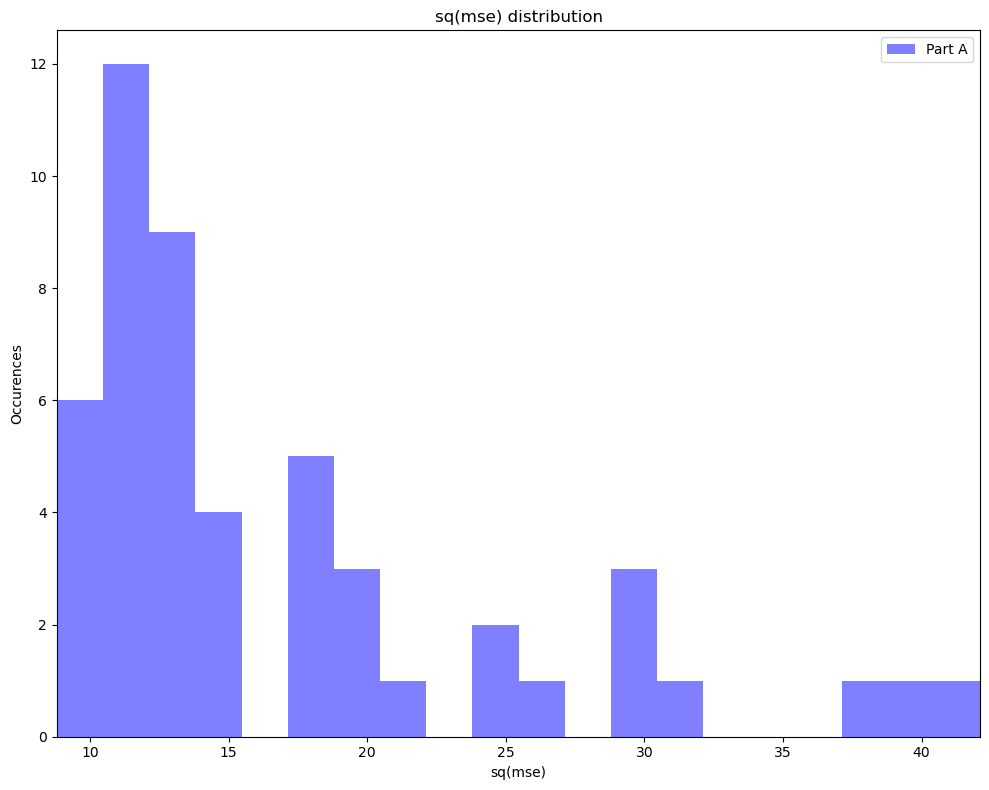

In [47]:
plot_results(result_list = [sq_mse_list_A],
             label_list  = ["Part A"],
             var_name = "sq(mse)",
             figsize = figsize,
             nbins = nbins)

In [48]:
# Just launch the function above (train_and_test_several_models), but with pred_norm = True
sq_mse_list_B = train_and_test_several_models(X = X,
                                              y = y,
                                              test_size   = test_size,
                                              model_arch  = model_architecture1,
                                              input_shape = input_shape,
                                              optimizer   = "adam",
                                              loss        = "mean_squared_error",
                                              niterations = niterations,
                                              epochs      = 50,
                                              seed        = 3675,
                                              verbose     = 0,
                                              pred_norm   = True,
                                             )


Launching 50 iterations of
 - train/test split => test_size = 0.3
 - Apply predictors normalization
 - model architecture: {'layer_1': {'n_units': 10, 'activation': 'relu'}, 'layer_2': {'n_units': 1}}
 - model training:
   * epochs    = 50
   * optimizer = adam
   * loss      = mean_squared_error

Train/test splitting for iteration 1
  X_train.shape = (721, 8)
  y_train.shape = (721,)
  X_test.shape  = (309, 8)
  y_test.shape  = (309,)
       Cement  Blast Furnace Slag   Fly Ash     Water  Superplasticizer  \
723  0.260617           -0.863998 -0.825639  0.448707         -1.007613   
112  1.477748            1.174001 -0.825639  0.163870          0.870100   
278 -0.292281           -0.863998  1.058232  0.282552         -0.026465   
641 -0.305490           -0.863998 -0.825639 -0.026021         -1.007613   
270 -0.477209           -0.863998  1.110782 -0.405804          0.125781   

     Coarse Aggregate  Fine Aggregate       Age  
723          0.481434        0.718580 -0.271735  
112     

In [49]:
# Calculate the mean and the standard deviation of the metric on the 50 samplings
mean_sqmse_B = np.mean(sq_mse_list_B)
std_sqmse_B  = np.std(sq_mse_list_B)

df_results.loc[df_results.shape[0]] = ["B",mean_sqmse_B,std_sqmse_B]
df_results

,Part,mean_sq_mse,std_sq_mse
0,A,17.056502,8.251775
1,B,18.724610,2.437705


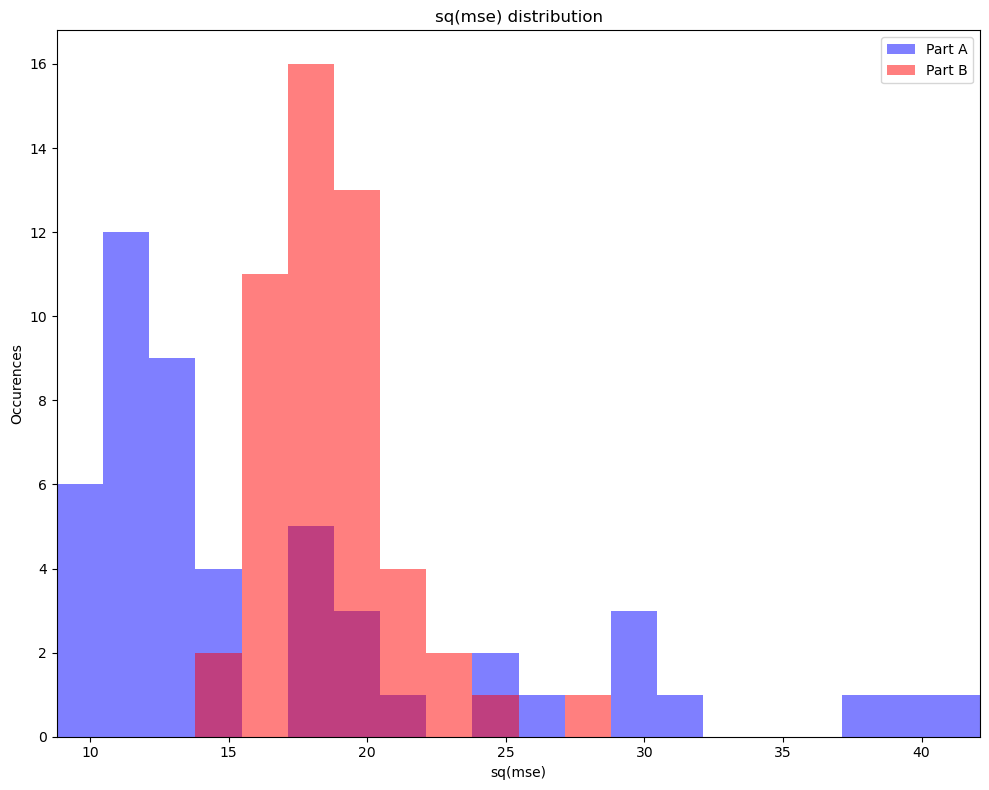

In [50]:
plot_results(result_list = [sq_mse_list_A,sq_mse_list_B],
             label_list  = ["Part A","Part B"],
             var_name = "sq(mse)",
             figsize = figsize,
             nbins = nbins)

In [51]:
# Just launch the function above (train_and_test_several_models), but with pred_norm = True and epochs = 100
sq_mse_list_C = train_and_test_several_models(X = X,
                                              y = y,
                                              test_size   = test_size,
                                              model_arch  = model_architecture1,
                                              input_shape = input_shape,
                                              optimizer   = "adam",
                                              loss        = "mean_squared_error",
                                              niterations = niterations,
                                              epochs      = 100,
                                              seed        = 3675,
                                              verbose     = 0,
                                              pred_norm   = True,
                                             )


Launching 50 iterations of
 - train/test split => test_size = 0.3
 - Apply predictors normalization
 - model architecture: {'layer_1': {'n_units': 10, 'activation': 'relu'}, 'layer_2': {'n_units': 1}}
 - model training:
   * epochs    = 100
   * optimizer = adam
   * loss      = mean_squared_error

Train/test splitting for iteration 1
  X_train.shape = (721, 8)
  y_train.shape = (721,)
  X_test.shape  = (309, 8)
  y_test.shape  = (309,)
       Cement  Blast Furnace Slag   Fly Ash     Water  Superplasticizer  \
723  0.260617           -0.863998 -0.825639  0.448707         -1.007613   
112  1.477748            1.174001 -0.825639  0.163870          0.870100   
278 -0.292281           -0.863998  1.058232  0.282552         -0.026465   
641 -0.305490           -0.863998 -0.825639 -0.026021         -1.007613   
270 -0.477209           -0.863998  1.110782 -0.405804          0.125781   

     Coarse Aggregate  Fine Aggregate       Age  
723          0.481434        0.718580 -0.271735  
112    

In [52]:
# Calculate the mean and the standard deviation of the metric on the 50 samplings
mean_sqmse_C = np.mean(sq_mse_list_C)
std_sqmse_C  = np.std(sq_mse_list_C)

df_results.loc[df_results.shape[0]] = ["C",mean_sqmse_C,std_sqmse_C]
df_results

,Part,mean_sq_mse,std_sq_mse
0,A,17.056502,8.251775
1,B,18.724610,2.437705
2,C,12.724419,0.609505


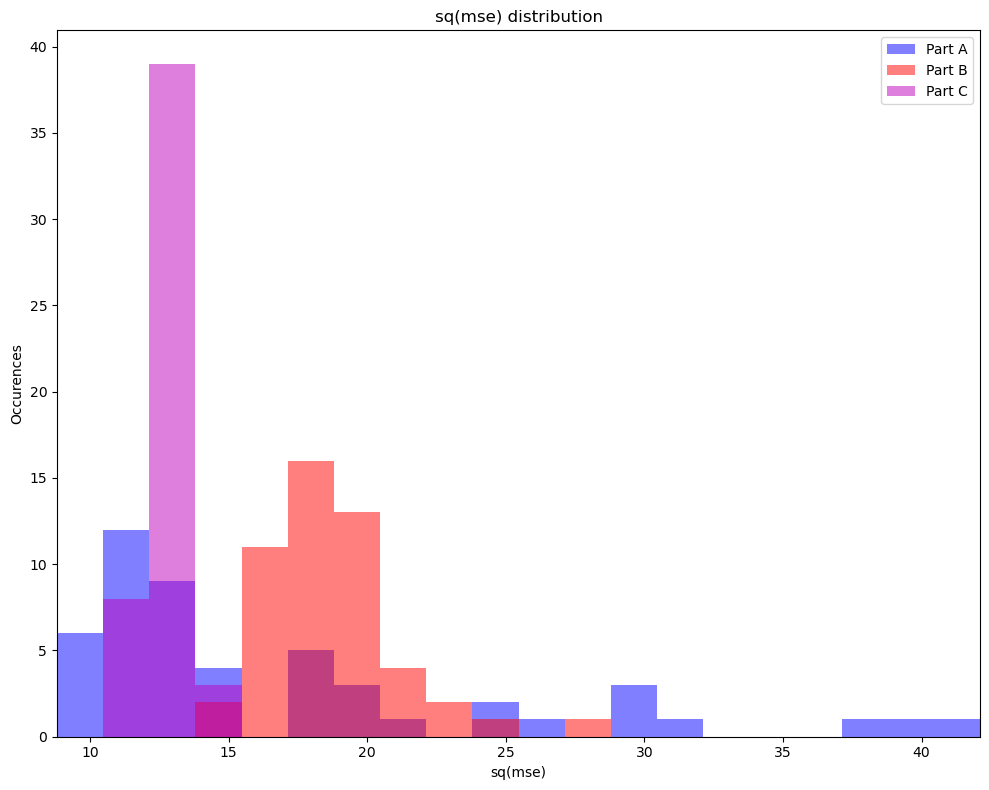

In [53]:
plot_results(result_list = [sq_mse_list_A, sq_mse_list_B, sq_mse_list_C],
             label_list  = ["Part A","Part B","Part C"],
             var_name = "sq(mse)",
             figsize = figsize,
             nbins = nbins)

In [54]:
# Define the new architecture
# model architecture
model_architecture2 = {"layer_1": {"n_units": 10, "activation": "relu"},
                       "layer_2": {"n_units": 10, "activation": "relu"},
                       "layer_3": {"n_units": 10, "activation": "relu"},
                       "layer_4": {"n_units":  1},
                      }

print()
print("input_shape    = {}".format(input_shape))
print("network_config = {}".format(model_architecture2))
print()


input_shape    = (8,)
network_config = {'layer_1': {'n_units': 10, 'activation': 'relu'}, 'layer_2': {'n_units': 10, 'activation': 'relu'}, 'layer_3': {'n_units': 10, 'activation': 'relu'}, 'layer_4': {'n_units': 1}}



In [55]:
# Just launch the function above (train_and_test_several_models), but with pred_norm = True 
# and model_arch = model_architecture2 and epochs = 100
sq_mse_list_D = train_and_test_several_models(X = X,
                                              y = y,
                                              test_size   = test_size,
                                              model_arch  = model_architecture2,
                                              input_shape = input_shape,
                                              optimizer   = "adam",
                                              loss        = "mean_squared_error",
                                              niterations = niterations,
                                              epochs      = 50,
                                              seed        = 3675,
                                              verbose     = 0,
                                              pred_norm   = True,
                                             )


Launching 50 iterations of
 - train/test split => test_size = 0.3
 - Apply predictors normalization
 - model architecture: {'layer_1': {'n_units': 10, 'activation': 'relu'}, 'layer_2': {'n_units': 10, 'activation': 'relu'}, 'layer_3': {'n_units': 10, 'activation': 'relu'}, 'layer_4': {'n_units': 1}}
 - model training:
   * epochs    = 50
   * optimizer = adam
   * loss      = mean_squared_error

Train/test splitting for iteration 1
  X_train.shape = (721, 8)
  y_train.shape = (721,)
  X_test.shape  = (309, 8)
  y_test.shape  = (309,)
       Cement  Blast Furnace Slag   Fly Ash     Water  Superplasticizer  \
723  0.260617           -0.863998 -0.825639  0.448707         -1.007613   
112  1.477748            1.174001 -0.825639  0.163870          0.870100   
278 -0.292281           -0.863998  1.058232  0.282552         -0.026465   
641 -0.305490           -0.863998 -0.825639 -0.026021         -1.007613   
270 -0.477209           -0.863998  1.110782 -0.405804          0.125781   

     Coa

In [56]:
# Calculate the mean and the standard deviation of the metric on the 50 samplings
mean_sqmse_D = np.mean(sq_mse_list_D)
std_sqmse_D  = np.std(sq_mse_list_D)

df_results.loc[df_results.shape[0]] = ["D",mean_sqmse_D,std_sqmse_D]
df_results

,Part,mean_sq_mse,std_sq_mse
0,A,17.056502,8.251775
1,B,18.724610,2.437705
2,C,12.724419,0.609505
3,D,11.092570,0.840787


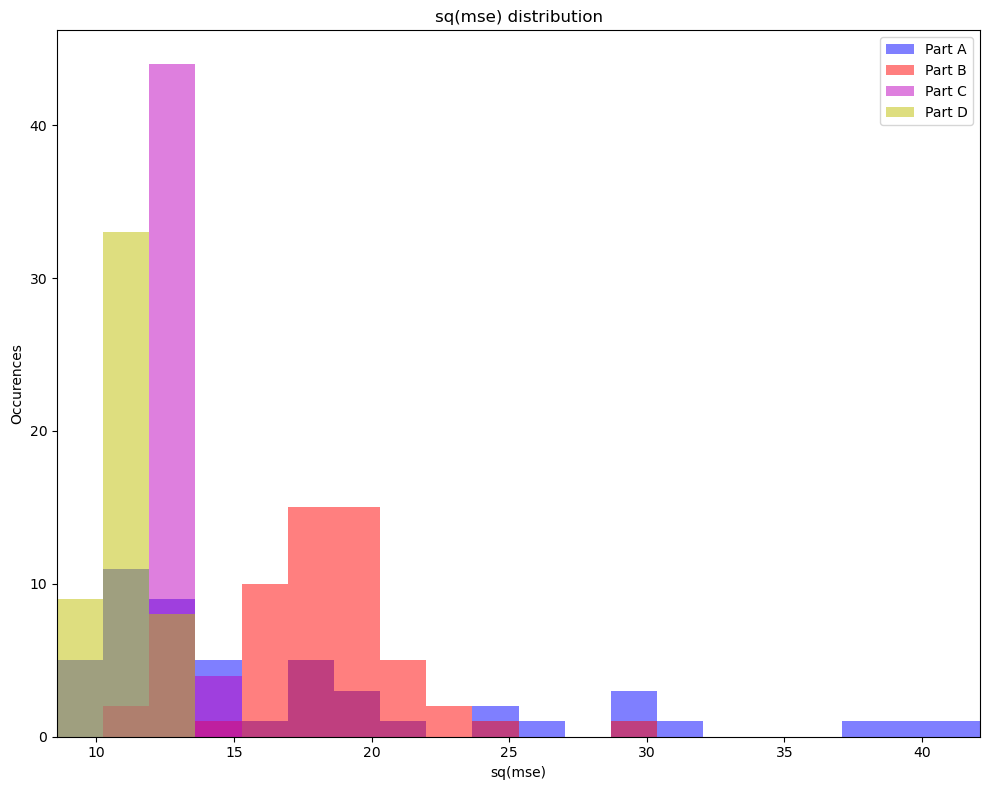

In [57]:
plot_results(result_list = [sq_mse_list_A, sq_mse_list_B, sq_mse_list_C,sq_mse_list_D],
             label_list  = ["Part A","Part B","Part C","Part D"],
             var_name = "sq(mse)",
             figsize = figsize,
             nbins = nbins)